In [1]:
# Imports
import numpy as np
import pandas as pd
import quantstats as qs
import requests


In [9]:
# Function to fetch OHLC data from Kraken API
def fetch_ohlc_data(pair, interval='1440'):  # 1440 for daily data
    url = f'https://api.kraken.com/0/public/OHLC?pair={pair}&interval={interval}'
    response = requests.get(url).json()
    if response['error']:
        raise ValueError(f"Error fetching data for {pair}: {response['error']}")
    data = response['result']
    key = list(data.keys())[0]  # Pair key
    ohlc = pd.DataFrame(data[key], columns=[
        'time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'
    ])
    ohlc['time'] = pd.to_datetime(ohlc['time'], unit='s')
    ohlc.set_index('time', inplace=True)
    ohlc = ohlc.astype(float)
    return ohlc

# Fetch OHLC data for assets
btc = fetch_ohlc_data('XXBTZUSD')
sol = fetch_ohlc_data('SOLUSD')
msol = fetch_ohlc_data('MSOLUSD')
xrp = fetch_ohlc_data('XRPUSD')
ada = fetch_ohlc_data('ADAUSD')
avax = fetch_ohlc_data('AVAXUSD')

# Align the data
data = pd.concat([
    btc['close'].rename('BTC'),
    sol['close'].rename('SOL'),
    msol['close'].rename('MSOL'),
    xrp['close'].rename('XRP'),
    ada['close'].rename('ADA'),
    avax['close'].rename('AVAX')
], axis=1).dropna()

# Construct index
weights = {'BTC': 0.5, 'ADA': 0.1, 'AVAX': 0.1, 'MSOL': 0.15, 'XRP': 0.05}
index = (data * pd.Series(weights)).sum(axis=1)

# Calculate EMAs
index_ema_9 = index.ewm(span=9, adjust=False).mean()
index_ema_21 = index.ewm(span=21, adjust=False).mean()

# Generate signals
# 1: Buy, -1: Sell
signal = np.where(index_ema_9 > index_ema_21, 1, -1)

# Shift signals to avoid lookahead bias
position = pd.Series(signal, index=index.index).shift(1).fillna(0)

# Backtest
daily_returns = index.pct_change().fillna(0)
strategy_returns = daily_returns * position

# Ensure QuantStats returns are correctly formatted
strategy_returns = strategy_returns.dropna()
daily_returns = daily_returns.dropna()



In [12]:
# Ensure strategy_returns is aligned properly for QuantStats
strategy_returns.name = "EMA Strategy"
daily_returns.name = "Benchmark"

# Generate HTML tearsheet
qs.reports.html(
    returns=strategy_returns,
    benchmark=daily_returns,
    title="EMA Crossover Strategy Backtest",
    output="EMA_Crossover_Strategy_Report.html"
)

c:\Users\ayode\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\ayode\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\ayode\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain t

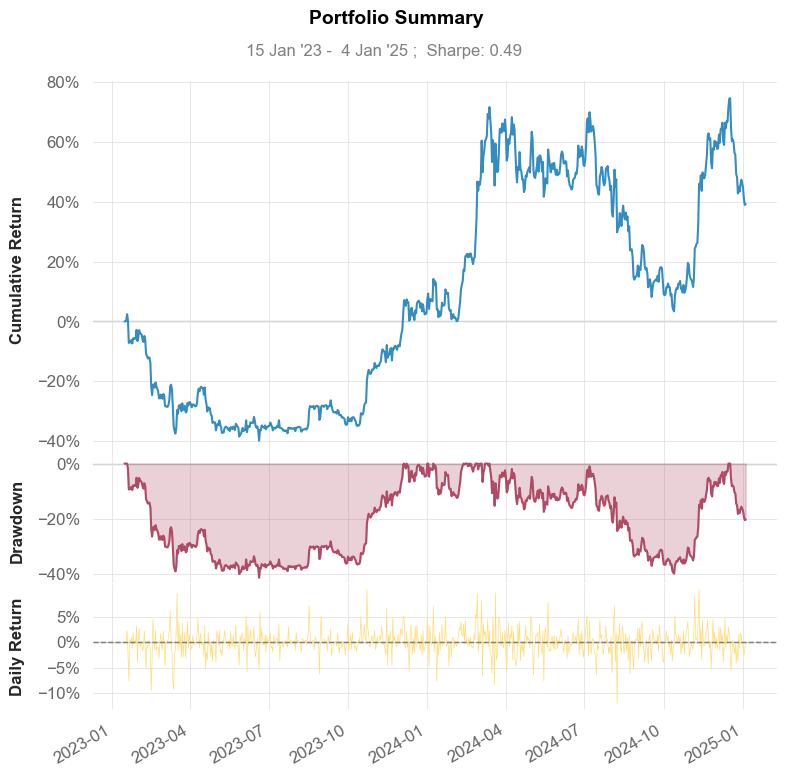

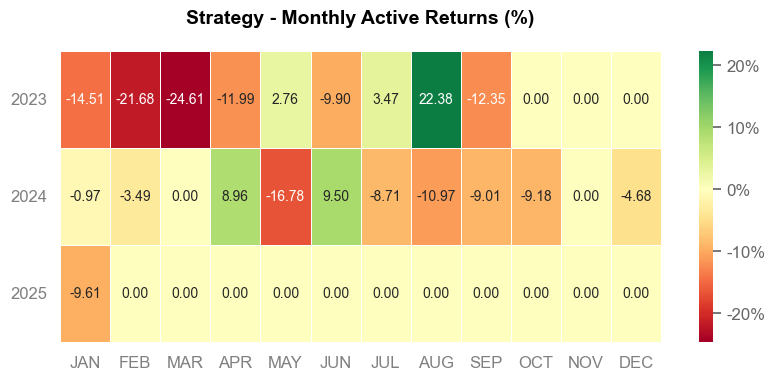

In [13]:
# Grab charts of cummulatives returns, and drawdowns
qs.reports.plots(
    returns=strategy_returns,
    benchmark=daily_returns,
    mode="basic",
    display=False
)